# Near Miss Development: V1
- Scale Implementation

In [2]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import time

import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt

PLACE_HOLDER = None

## Begin Near Miss Development Here:

#### Function IO

In [ ]:
def nearmiss_dist_v1(x, y, k):
    """
    Parameters:
    x : Long time series data (numpy array)
    y : Query sequence (numpy array)  
    k : Size of pieces, preferably a power of two (int)
    
    Returns:
    dist : Distance profile (numpy array)
    """

# Development V1 Objective:
- Account for scale of certain features (i.e. acceleration, lateral velocity. etc. )

## Proposition:
- Create a mass function for unnormalized comparisons between queries and trips
- Compute the Normalized (Pattern Influence) and Unnormalized (Scale Influence) distance function for each feature
- Combined distance function for each feature: D_combined = w_pattern * D_normalized + w_scale * D_unnormalized
- This will create a matrix of weights for each feature which can be initialized through domain knowledge, and then fine-tuned through cross-validation.

#### Normalized Mass Function:
- Reimplementation of MASS V3 --> Lets call it: Near-miss Shape Profile

In [4]:
# Normalized distance function (pattern matching) - Essentially MASS V3 in python
def nm_shape(x, y, k):
    """
    Parameters:
    x : numpy array
        Long time series data
    y : numpy array
        Query sequence
    k : int
        Size of pieces, preferably a power of two
    Returns:
    dist : numpy array
        Normalized distance profile
    """
    m = len(y)
    n = len(x)
    expected_length = n - m + 1
    dist = []

    # Compute statistics for the query y
    meany = np.mean(y)
    sigmay = np.std(y, ddof=0)

    # Compute moving mean and standard deviation for x
    meanx = np.convolve(x, np.ones(m), 'valid') / m
    sum_sq = np.convolve(x ** 2, np.ones(m), 'valid')
    sigmax = np.sqrt((sum_sq - m * meanx ** 2) / m)

    # Reverse the query and pad with zeros to match size k
    y = y[::-1]
    y = np.concatenate((y, np.zeros(k - m)))

    # Loop through segments of the time series
    for j in range(0, n - k + 1, k - m + 1):
        X = np.fft.fft(x[j:j + k])
        Y = np.fft.fft(y)
        Z = X * Y
        z = np.fft.ifft(Z)
        d = 2 * (m - (z[m - 1:k] - m * meanx[j:j + k - m + 1] * meany) / (sigmax[j:j + k - m + 1] * sigmay))
        dist.extend(np.sqrt(np.real(d)))

    # Handle the last segment if it is longer than the query
    j = j + k - m
    remaining_length = n - j
    if remaining_length >= m:
        X = np.fft.fft(x[j:])
        y = y[:remaining_length]
        Y = np.fft.fft(y)
        Z = X * Y
        z = np.fft.ifft(Z)
        d = 2 * (m - (z[m - 1:remaining_length] - m * meanx[j:j + remaining_length - m + 1] * meany) / (sigmax[j:j + remaining_length - m + 1] * sigmay))
        dist.extend(np.sqrt(np.real(d)))

    # Ensure consistent length
    dist = np.array(dist)
    if len(dist) > expected_length:
        dist = dist[:expected_length]
    elif len(dist) < expected_length:
        dist = np.pad(dist, (0, expected_length - len(dist)), 'constant', constant_values=np.nan)

    return dist

#### Unnormalized Mass Function:
- Similar to MASS however it doesn't z-normalize, therefor it accounts for scale
- Lets call this Near-Miss Scale Profile

In [3]:
# Unnormalized distance function (magnitude sensitivity)
def nm_scale(x, y, k):
    """
    Parameters:
    x : numpy array
        Long time series data
    y : numpy array
        Query sequence
    k : int
        Size of pieces, preferably a power of two
    Returns:
    dist : numpy array
        Unnormalized distance profile
    """
    m = len(y)
    n = len(x)
    expected_length = n - m + 1
    dist = []

    y = y[::-1]
    y = np.concatenate((y, np.zeros(k - m)))

    for j in range(0, n - k + 1, k - m + 1):
        X = np.fft.fft(x[j:j + k])
        Y = np.fft.fft(y)
        Z = X * Y
        z = np.fft.ifft(Z)
        d = np.sqrt(np.abs(np.real(z[m - 1:k])))
        dist.extend(d)

    # Handle the last segment if it is longer than the query
    j = j + k - m
    remaining_length = n - j
    if remaining_length >= m:
        X = np.fft.fft(x[j:])
        y = y[:remaining_length]
        Y = np.fft.fft(y)
        Z = X * Y
        z = np.fft.ifft(Z)
        d = np.sqrt(np.abs(np.real(z[m - 1:remaining_length])))
        dist.extend(d)

    # Ensure consistent length
    dist = np.array(dist)
    if len(dist) > expected_length:
        dist = dist[:expected_length]
    elif len(dist) < expected_length:
        dist = np.pad(dist, (0, expected_length - len(dist)), 'constant', constant_values=np.nan)

    return dist


### Function for determining the optimal value for k (number of pieces):

In [5]:
def determine_k(n, m):
    """
    Determines the optimal value of k for MASS V3.
    
    Parameters:
    n : Length of the time series (int) 
    m : Length of the query (int)

    Returns:
    k : Optimal segment size, preferably a power of two (int)
    """
    # Set k to be the next power of two greater than or equal to 4 times the query length
    k = 2 ** int(np.ceil(np.log2(max(4 * m, m))))
    # Ensure k is not greater than the length of the time series
    k = min(k, n)
    return k

## Test Implementation

In [6]:
# Load the query and trip data (1 query and 1 trip)
x = pd.read_csv(r'C:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\data\x_trip_5109.csv')
y = pd.read_csv(r'C:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\data\y_query_7.csv')


In [7]:
# Determine the optimal segment size
n = len(x)
m = len(y)
k = determine_k(n, m)

In [8]:
# The initial columns to compare in the time series data
columns = ['veh_long_vel_mps', 'veh_accel_mps2_analytical', 'veh_ltrl_vel_mps', 'veh_yaw_rate_radps', 'veh_jerk_mps3_analytical']

In [9]:
# Set initial weights for each feature

weights = {
'veh_long_vel_mps': {'w_pattern': 1, 'w_scale': 0},
'veh_accel_mps2_analytical': {'w_pattern': 0, 'w_scale': 1},
'veh_ltrl_vel_mps': {'w_pattern': 0, 'w_scale': 1},
'veh_yaw_rate_radps': {'w_pattern': 1, 'w_scale': 0},
'veh_jerk_mps3_analytical': {'w_pattern': 1, 'w_scale': 0}
}

In [10]:
print("Test Description: This test is for Near Miss algorithm v1 implementation")

start_time = time.time()

# Initialize combined distance profile for the first feature
feature_name = columns[0]
w_pattern = weights[feature_name]['w_pattern']
w_scale = weights[feature_name]['w_scale']
combined_distance_profile = (w_pattern * nm_shape(x[feature_name].values, y[feature_name].values, k) +
                             w_scale * nm_scale(x[feature_name].values, y[feature_name].values, k))

# Loop through each column and compute the distance profile for remaining features
for col in columns[1:]:
    w_pattern = weights[col]['w_pattern']
    w_scale = weights[col]['w_scale']
    distance_profile_shape = nm_shape(x[col].values, y[col].values, k)
    distance_profile_scale = nm_scale(x[col].values, y[col].values, k)
    
    # Ensure lengths are consistent by trimming or padding
    min_len = min(len(distance_profile_shape), len(distance_profile_scale))
    distance_profile_shape = distance_profile_shape[:min_len]
    distance_profile_scale = distance_profile_scale[:min_len]
    
    combined_distance_profile += (w_pattern * distance_profile_shape + w_scale * distance_profile_scale)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Test Description: This test is for Near Miss algorithm v1 implementation
Time taken: 0.08459877967834473 seconds


C:\Users\donav\AppData\Local\Temp\ipykernel_55064\1878232234.py:39: RuntimeWarning: divide by zero encountered in divide
  d = 2 * (m - (z[m - 1:k] - m * meanx[j:j + k - m + 1] * meany) / (sigmax[j:j + k - m + 1] * sigmay))
C:\Users\donav\AppData\Local\Temp\ipykernel_55064\1878232234.py:39: RuntimeWarning: invalid value encountered in divide
  d = 2 * (m - (z[m - 1:k] - m * meanx[j:j + k - m + 1] * meany) / (sigmax[j:j + k - m + 1] * sigmay))
C:\Users\donav\AppData\Local\Temp\ipykernel_55064\1878232234.py:39: RuntimeWarning: invalid value encountered in multiply
  d = 2 * (m - (z[m - 1:k] - m * meanx[j:j + k - m + 1] * meany) / (sigmax[j:j + k - m + 1] * sigmay))


# Analysis
- What does this new distance profile look like?

In [11]:
# Plot Distance Profile Function using seaborn
def plot_distance_profile(distance_profile):
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=distance_profile)
    plt.title(f'Multivariate Distance Profile for Selected Trip', fontsize=16, fontweight='bold')
    plt.xlabel('Index', fontsize=14)
    plt.ylabel('Euclidean Distance', fontsize=14)
    plt.grid(True)
    plt.xlim(left=0)  # Ensure x-axis starts at 0
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.show()

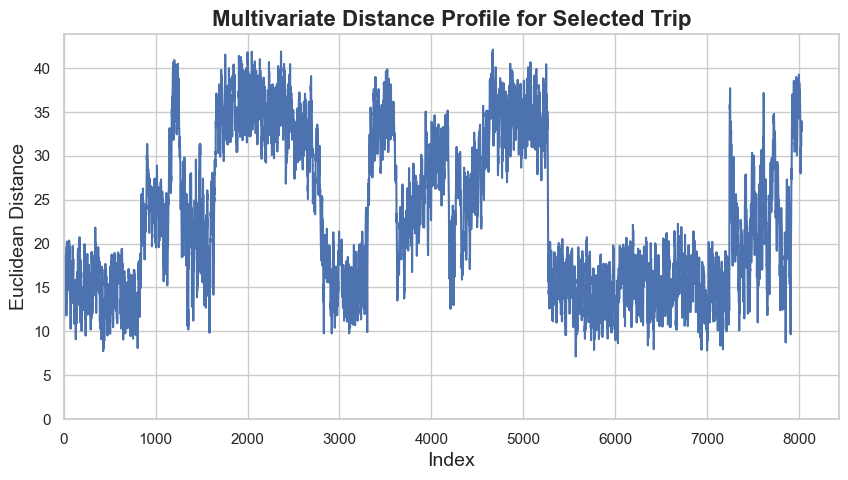

In [12]:
# Plot the combined distance profile
plot_distance_profile(combined_distance_profile)